In [1]:
import os
import numpy as np
import pydicom as dicom
import cv2 # opencv-python
import SimpleITK as sitk
from skimage import morphology
from skimage.measure import label
from matplotlib import pyplot as plt

In [2]:
im1_path = os.path.join("RADCURE NRRD.nrrd")
im1_im = sitk.ReadImage(im1_path)
im1 = sitk.GetArrayFromImage(im1_im) 
print(im1.shape)

im2_path = os.path.join("CTChest-1.nrrd")
im2_im = sitk.ReadImage(im2_path)
im2 = sitk.GetArrayFromImage(im2_im) 
print(im2.shape)

(187, 512, 512)
(139, 512, 512)


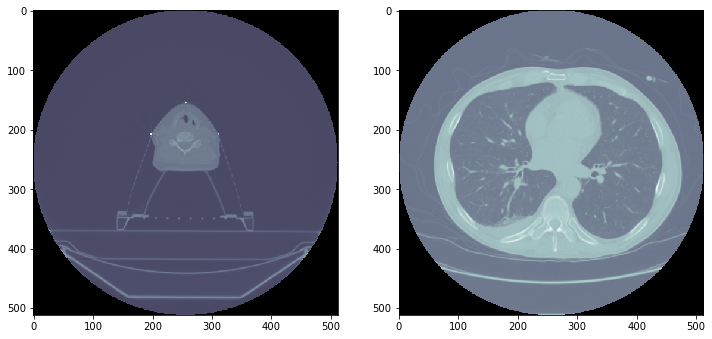

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
#ax[0].imshow(im1[im1.shape[0]//2], CMAP='bone')
#ax[1].imshow(im2[im2.shape[0]//2], CMAP='bone')

midim1=im1[im1.shape[0]//2]
midim2=im2[im2.shape[0]//2]

ax[0].imshow(midim1, CMAP='bone')
ax[1].imshow(midim2, CMAP='bone')

In [4]:
print(np.amin(midim2))
print(np.amax(midim2))

-3024
1186


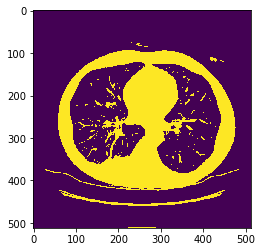

In [5]:
bodymask=(midim2>-718).astype(int) #apparently -718 to -177 is skin. since i am just interested in getting a mask of the greys, >-718 will suffice
plt.imshow(bodymask)



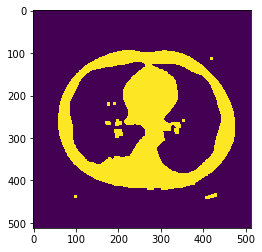

In [6]:
bodymask8=np.uint8(bodymask)

kernel = np.ones((7,7),np.uint8)
bodymaskrefine = cv2.morphologyEx(bodymask8, cv2.MORPH_OPEN, kernel)

plt.imshow(bodymaskrefine)

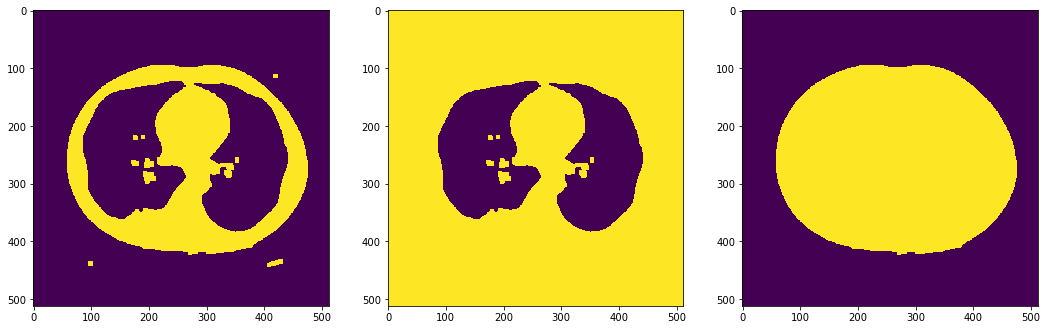

In [7]:
im_floodfill = bodymaskrefine.copy()
h, w = bodymaskrefine.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(im_floodfill, mask, (0,0), 1)

th, prefinalmask = cv2.threshold(im_floodfill, 0, 1, cv2.THRESH_BINARY_INV)
finalmask= label(prefinalmask|bodymaskrefine)
finalmask = morphology.remove_small_objects(finalmask,min_size=300, connectivity=1)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(bodymaskrefine)
ax[1].imshow(im_floodfill)
ax[2].imshow(finalmask)

In [8]:
#dont even need the full body mask... just use the first image above to apply the itsa
#find the min bone hounsfield value, threshold the image, find the 2 standard deviations below the mean of the thresholded
#initiate itsa with 2 SD image and the body mask

In [10]:
bodyseg=bodymaskrefine*midim2
#apply to body mask to get rid of outside shit

bonemask_1= (bodyseg>148).astype(int) #bone minimum hounsfield unit (roughly searched form google images)



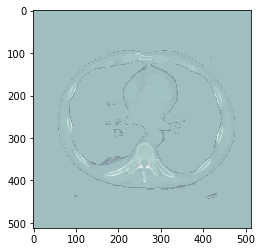

In [11]:
plt.imshow(bodyseg, cmap='bone', vmin=-3024, vmax=1186)


In [12]:
bonemask_2 = np.ma.masked_where(bonemask_1 == 0, bonemask_1)

boneseg_in=bonemask_2*midim2


print(np.amax(boneseg_in))
print(np.amin(boneseg_in))
print(np.mean(boneseg_in))
print(np.std(boneseg_in))

1186
149
313.29992905285565
154.48980205610712


1


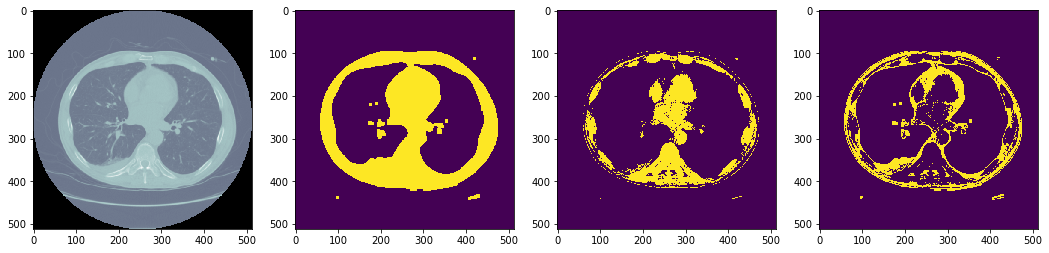

In [13]:
bone_th=(np.mean(boneseg_in)-2*np.std(boneseg_in))
bone_in=(bodyseg>bone_th).astype(int)

soft_t=bodymaskrefine-bone_in

fig, ax = plt.subplots(1, 4, figsize=(18, 6))
ax[0].imshow(midim2, cmap='bone')
ax[1].imshow(bodymaskrefine)
ax[2].imshow(bone_in)
ax[3].imshow(soft_t)
print(np.amax(soft_t))

In [14]:
#body mask refine = Mi
#itsa_in=Fi
#dont need bonemask_in. this is just used to find the SD

Revised Threshold=-457.5500570834858
	Mean SOFT TISSUE Intensity=-134.0530297623296 pixels
	Mean BONE Intensity=94.85766252836737 pixels


Revised Threshold=4721.460313118208
	Mean SOFT TISSUE Intensity=1453.5334161766982 pixels
	Mean BONE Intensity=-1164.4438840530458 pixels


Revised Threshold=0.0
	Mean SOFT TISSUE Intensity=-15.76447763253199 pixels
	Mean BONE Intensity=0.0 pixels




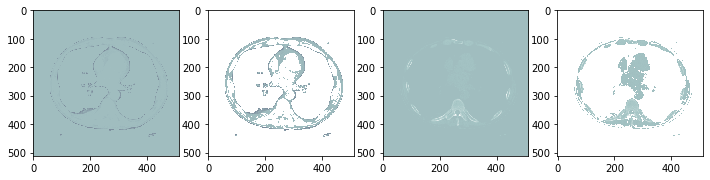

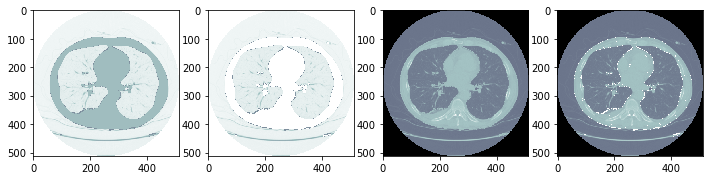

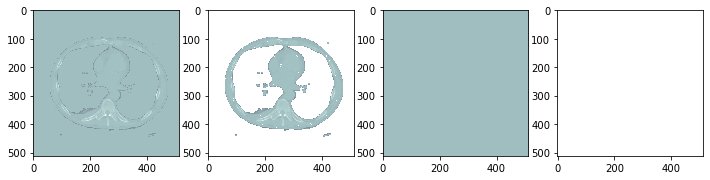

In [15]:
#Display threshold evolution and image evolution

k=1
ThPrev=0 #previous
ThRev=bone_th #revised

#apply threshold
while ThRev!=ThPrev: #while new threshold is NOT equal to prev threshold

    ThPrev=ThRev #update the previous threshold for comparison in subsequent iterations
    
    prebonemask = label(bodyseg>ThRev)
    
    bonemask = (morphology.remove_small_objects(prebonemask,min_size=8, connectivity=1)).astype(int) 
    
    bonemask = cv2.normalize(src=bonemask, dst=None, alpha=0.0, beta=255.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    ret, bonemask = cv2.threshold(bonemask,0,1,cv2.THRESH_BINARY) 
    boneseg1 = bonemask*midim2

    preMuscSegP=bodyseg-boneseg1  #ROI-fat=muscle

    #masking the 0's in the image to exclude in the mean calculations
    MuscSegP=np.ma.masked_where(preMuscSegP == 0, preMuscSegP)
    boneSegP=np.ma.masked_where(boneseg1==0,boneseg1) 

    #Calculate mean signal intensities
    MuscSegI=np.mean(MuscSegP)
    boneSegI=np.mean(boneSegP)
    
    #Threshold optimization equation
    ThRev=(1+((boneSegI-MuscSegI)/boneSegI))*MuscSegI 

    fig, axs = plt.subplots (1,4, figsize=(12,4))  
    axs[0].imshow(preMuscSegP, cmap='bone', vmin=-3024, vmax=1186) 
    axs[1].imshow(MuscSegP,cmap="bone", vmin=-3024, vmax=1186)
    axs[2].imshow(boneseg1,cmap="bone", vmin=-3024, vmax=1186)
    axs[3].imshow(boneSegP,cmap="bone", vmin=-3024, vmax=1186) 
    
    print(f"Revised Threshold={ThRev}\n\tMean SOFT TISSUE Intensity={MuscSegI} pixels\n\tMean BONE Intensity={boneSegI} pixels\n\n")

    k+=1
    if k==50:
        break
    

Revised Threshold=4.320324940641399
	Mean MUSCLE Intensity=-132.41130170831568 pixels
	Mean FAT Intensity=95.68213394483038 pixels


Revised Threshold=79.00523766044216
	Mean MUSCLE Intensity=-60.910946422062935 pixels
	Mean FAT Intensity=243.4917441860465 pixels


Revised Threshold=215.133295166449
	Mean MUSCLE Intensity=-43.29903851477292 pixels
	Mean FAT Intensity=376.97446696499077 pixels


Revised Threshold=325.0394050808386
	Mean MUSCLE Intensity=-32.41071174123682 pixels
	Mean FAT Intensity=491.6112920738328 pixels


Revised Threshold=413.502810313787
	Mean MUSCLE Intensity=-26.748458606334207 pixels
	Mean FAT Intensity=575.8221381267739 pixels


Revised Threshold=474.95845372367876
	Mean MUSCLE Intensity=-23.895712913647078 pixels
	Mean FAT Intensity=630.0540915395285 pixels


Revised Threshold=513.0196043559608
	Mean MUSCLE Intensity=-22.322421688635057 pixels
	Mean FAT Intensity=662.8468468468468 pixels


Revised Threshold=535.5139398813872
	Mean MUSCLE Intensity=-21.47753668

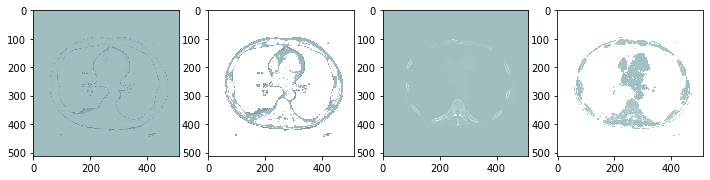

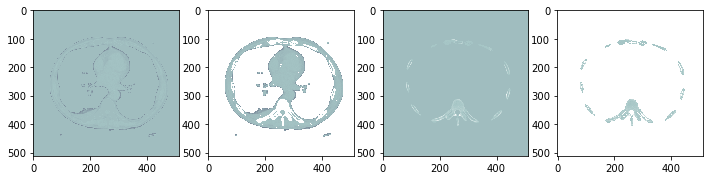

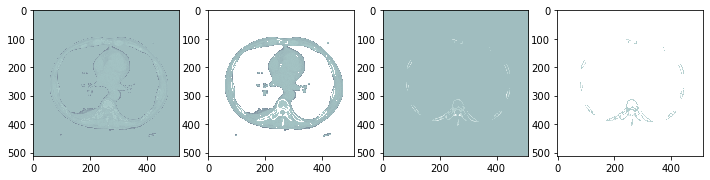

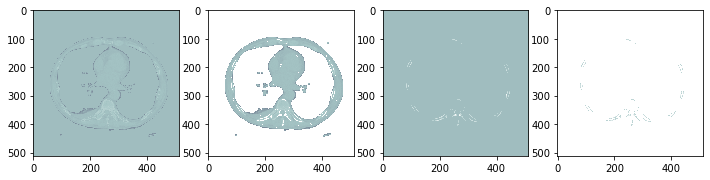

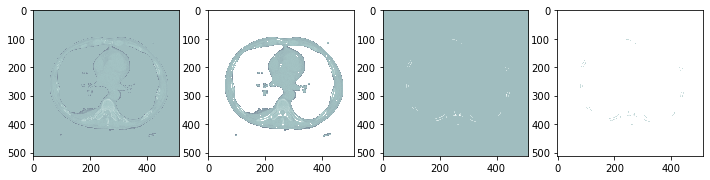

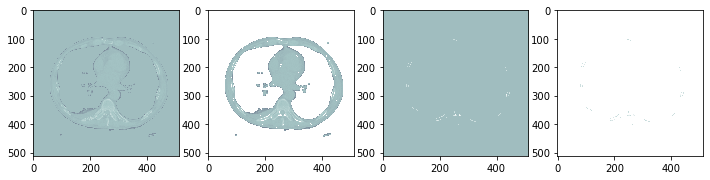

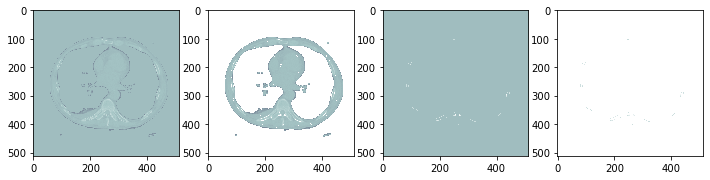

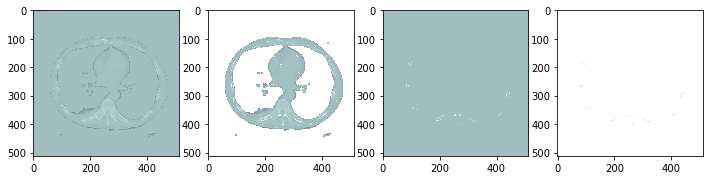

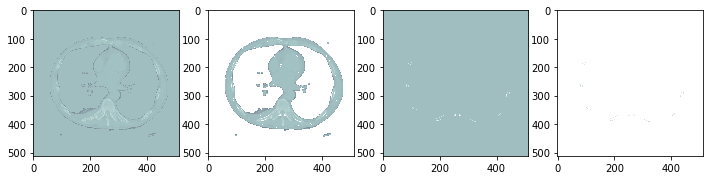

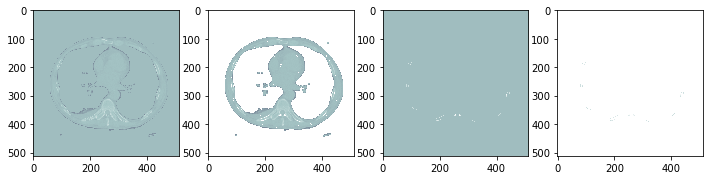

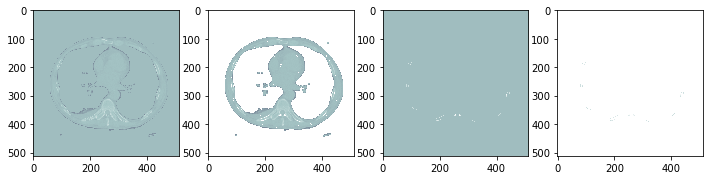

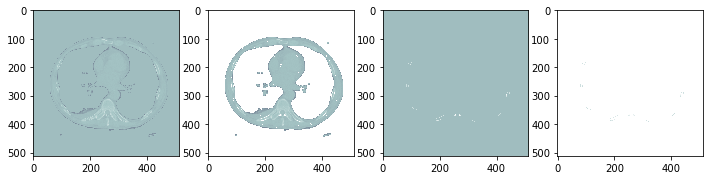

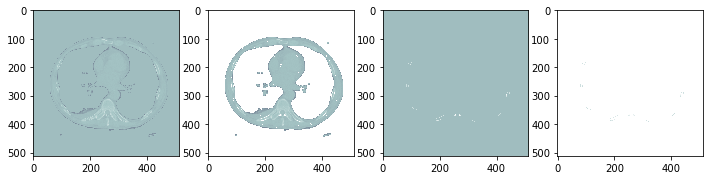

In [16]:
#Display threshold evolution and image evolution

k=1
ThPrev=0 #previous
ThRev=bone_th #revised

#apply threshold
while ThRev!=ThPrev: #while new threshold is NOT equal to prev threshold

    ThPrev=ThRev #update the previous threshold for comparison in subsequent iterations
    
    prefatmask = label(bodyseg>ThRev).astype(bool)
    
    fatmask = (morphology.remove_small_objects(prefatmask,min_size=8, connectivity=1)).astype(int) 
    
    fatmask = cv2.normalize(src=fatmask, dst=None, alpha=0.0, beta=255.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    ret, fatmask = cv2.threshold(fatmask,0,1,cv2.THRESH_BINARY) 
    fatseg1 = fatmask*bodyseg 

    preMuscSegP=bodyseg-fatseg1  #ROI-fat=muscle

    #masking the 0's in the image to exclude in the mean calculations
    MuscSegP=np.ma.masked_where(preMuscSegP == 0, preMuscSegP)
    FatSegP=np.ma.masked_where(fatseg1==0,fatseg1) 

    #Calculate mean signal intensities
    MuscSegI=np.mean(MuscSegP)
    FatSegI=np.mean(FatSegP)
    


    fig, axs = plt.subplots (1,4, figsize=(12,4))  
    axs[0].imshow(preMuscSegP, cmap='bone', vmin=0, vmax=255) 
    axs[1].imshow(MuscSegP,cmap="bone", vmin=0, vmax=255)
    axs[2].imshow(fatseg1,cmap="bone", vmin=0, vmax=255)
    axs[3].imshow(FatSegP,cmap="bone", vmin=0, vmax=255) 
    
    print(f"Revised Threshold={ThRev}\n\tMean MUSCLE Intensity={MuscSegI} pixels\n\tMean FAT Intensity={FatSegI} pixels\n\n")
    
    #Threshold optimization equation
    ThRev=((1+(((FatSegI+3024)-(MuscSegI+3024))/(FatSegI+3024)))*(MuscSegI+3024))-3024
    
    k+=1
    if k==50:
        break
    

In [17]:
#greyscale



Revised Threshold=4.320324940641399
	Mean MUSCLE Intensity=-132.41130170831568 pixels
	Mean FAT Intensity=95.68213394483038 pixels


Revised Threshold=79.00523766044216
	Mean MUSCLE Intensity=-60.910946422062935 pixels
	Mean FAT Intensity=243.4917441860465 pixels


Revised Threshold=215.133295166449
	Mean MUSCLE Intensity=-43.29903851477292 pixels
	Mean FAT Intensity=376.97446696499077 pixels


Revised Threshold=325.0394050808386
	Mean MUSCLE Intensity=-32.41071174123682 pixels
	Mean FAT Intensity=491.6112920738328 pixels


Revised Threshold=413.502810313787
	Mean MUSCLE Intensity=-26.748458606334207 pixels
	Mean FAT Intensity=575.8221381267739 pixels


Revised Threshold=474.95845372367876
	Mean MUSCLE Intensity=-23.895712913647078 pixels
	Mean FAT Intensity=630.0540915395285 pixels


Revised Threshold=513.0196043559608
	Mean MUSCLE Intensity=-22.322421688635057 pixels
	Mean FAT Intensity=662.8468468468468 pixels


Revised Threshold=535.5139398813872
	Mean MUSCLE Intensity=-21.47753668

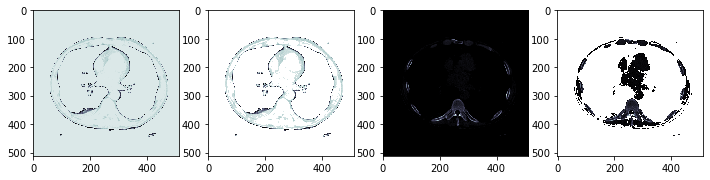

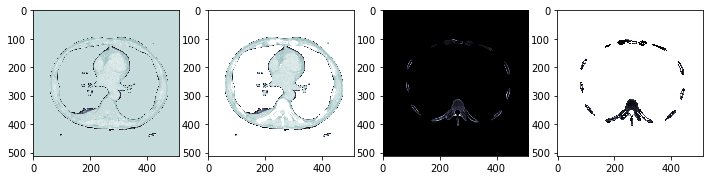

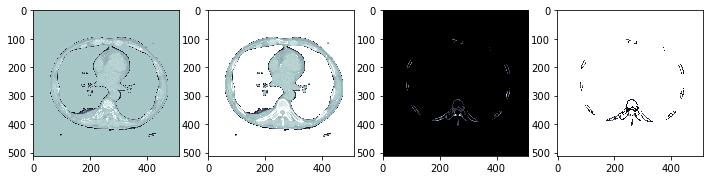

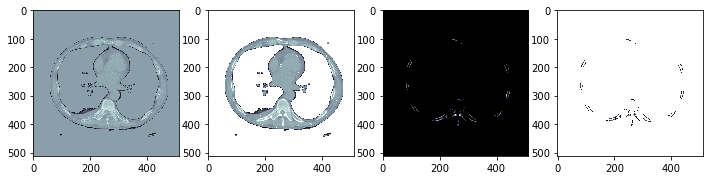

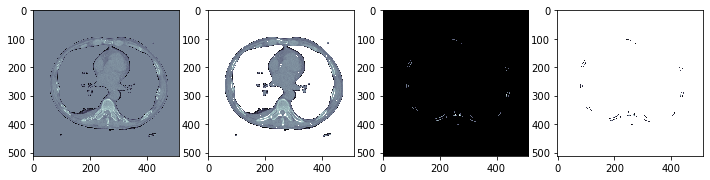

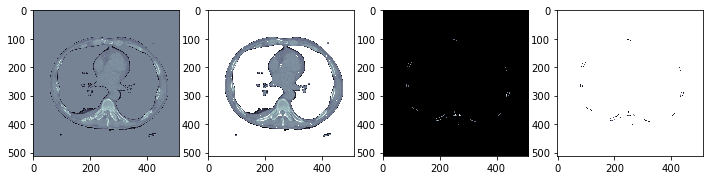

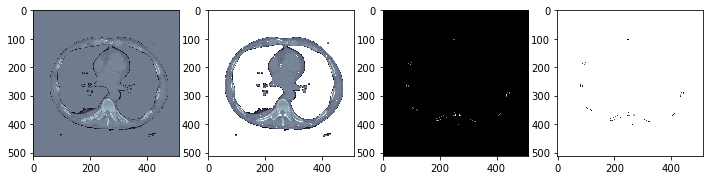

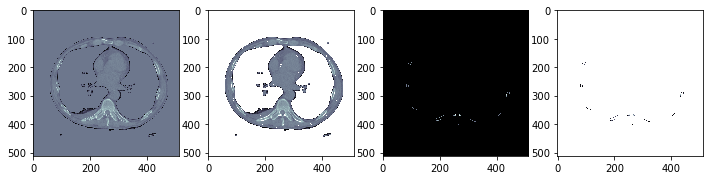

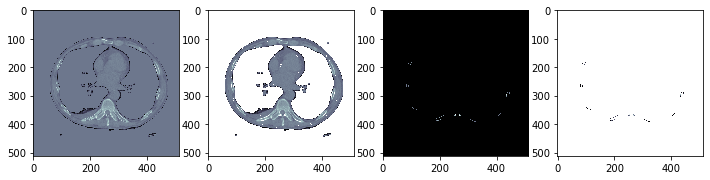

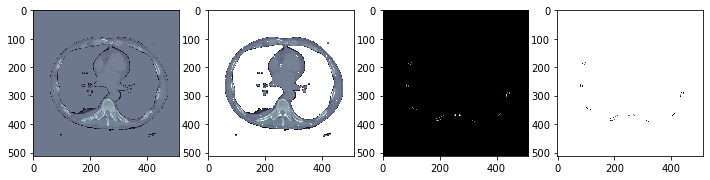

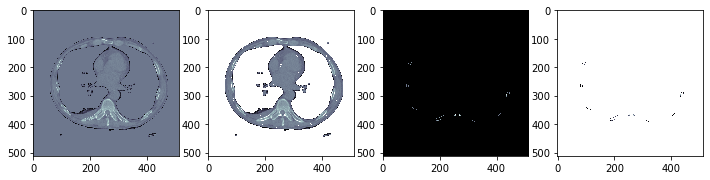

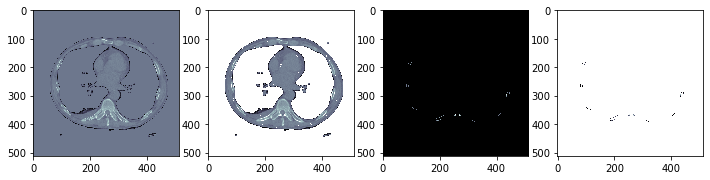

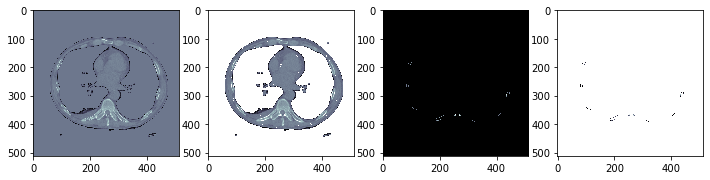

In [18]:
#Display threshold evolution and image evolution

k=1
ThPrev=0 #previous
ThRev=bone_th #revised

#apply threshold
while ThRev!=ThPrev: #while new threshold is NOT equal to prev threshold

    ThPrev=ThRev #update the previous threshold for comparison in subsequent iterations
    
    prefatmask = label(bodyseg>ThRev).astype(bool)
    
    fatmask = (morphology.remove_small_objects(prefatmask,min_size=8, connectivity=1)).astype(int) 
    
    fatmask = cv2.normalize(src=fatmask, dst=None, alpha=0.0, beta=255.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    ret, fatmask = cv2.threshold(fatmask,0,1,cv2.THRESH_BINARY) 
    fatseg1 = fatmask*bodyseg 

    preMuscSegP=bodyseg-fatseg1  #ROI-fat=muscle

    #masking the 0's in the image to exclude in the mean calculations
    MuscSegP=np.ma.masked_where(preMuscSegP == 0, preMuscSegP)
    FatSegP=np.ma.masked_where(fatseg1==0,fatseg1) 

    #Calculate mean signal intensities
    MuscSegI=np.mean(MuscSegP)
    FatSegI=np.mean(FatSegP)
    


    fig, axs = plt.subplots (1,4, figsize=(12,4))  
    axs[0].imshow(preMuscSegP, cmap='bone') 
    axs[1].imshow(MuscSegP,cmap="bone")
    axs[2].imshow(fatseg1,cmap="bone")
    axs[3].imshow(FatSegP,cmap="bone") 
    
    print(f"Revised Threshold={ThRev}\n\tMean MUSCLE Intensity={MuscSegI} pixels\n\tMean FAT Intensity={FatSegI} pixels\n\n")
    
    #Threshold optimization equation
    ThRev=((1+(((FatSegI+3024)-(MuscSegI+3024))/(FatSegI+3024)))*(MuscSegI+3024))-3024
    
    k+=1
    if k==50:
        break
    